<h1>Estimation de la covariance instantanée<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modèle-de-Heston" data-toc-modified-id="Modèle-de-Heston-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modèle de Heston</a></span></li><li><span><a href="#Fonctions-utiles" data-toc-modified-id="Fonctions-utiles-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Fonctions utiles</a></span></li><li><span><a href="#Noyau-Transformée-de-Fourier-non-uniforme" data-toc-modified-id="Noyau-Transformée-de-Fourier-non-uniforme-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Noyau Transformée de Fourier non uniforme</a></span></li><li><span><a href="#Calcul-des-coefficients-de-Fourier-de-la-matrice-de-covariance"" data-toc-modified-id="Calcul-des-coefficients-de-Fourier-de-la-matrice-de-covariance-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Calcul des coefficients de Fourier de la matrice de covariance</a></span></li><li><span><a  href="#Construction-de-la-matrice-de-covariance-instantanée" data-toc-modified-id="Construction-de-la-matrice-de-covariance-instantanée-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Construction de la matrice de covariance instantanée</a></span></li><li><span><a href="#Exemples" data-toc-modified-id="Exemples-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Exemples</a></span><ul class="toc-item">

In [1]:
import math
import time
import numpy as np
from cmath import exp
from numpy.fft import fft
from numpy.fft import fftfreq
from scipy.integrate import quad
from scipy.stats import random_correlation
from numpy.linalg import multi_dot
import random
import datetime
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import cmath

## Modèle de Heston

In [2]:
def heston(n, initial_log_prices, initial_covol, rho, M, alpha, dt) :
    Cov = [[[0,0],[0,0]] for i in range(n)]
    logp1 = [0 for i in range(n)]
    logp2 = [0 for i in range(n)]
    
    Sigma = np.sqrt(alpha)
    b = 3.5*alpha
    Cov[0] = initial_covol
    logp1[0] = initial_log_prices[0]
    logp2[0] = initial_log_prices[1]
    
    rands = []
    
    f = np.vectorize(cmath.sqrt)
    for i in range(1,n) :
        B = np.random.normal(size=(2,2))
        rands.append(B)
        prec = np.asarray(Cov[i-1])
        Cov[i] = prec + (b + M.dot(prec) + prec.dot(np.transpose(M)))*dt + multi_dot([f(prec),B,Sigma])*np.sqrt(dt) + multi_dot([Sigma,np.transpose(B), f(prec)])*np.sqrt(dt)
    
    for i in range(1,n) :
        W = np.random.normal(size=2)
        Z = np.sqrt(1-np.transpose(rho).dot(rho))*W + rands[i-1].dot(rho)
        logp = [logp1[i-1], logp2[i-1]] - 0.5*np.diag(Cov[i-1])*dt + f(np.asarray(Cov[i-1])).dot(Z)*np.sqrt(dt)
        logp1[i] = logp[0]
        logp2[i] = logp[1]
    
    return np.real(np.exp(logp1)), np.real(np.exp(logp2)), np.real(Cov)

## Fonctions utiles

In [3]:
def nearestPD(A):
    """Find the nearest (for the Frobenius norm) positive-definite matrix to input

    A Python/Numpy port of John D'Errico's nearestSPD MATLAB code [1], which
    credits [2] 
    
    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6

    A : list or np.array, symmetric
    
    taken from https://stackoverflow.com/questions/43238173/python-convert-matrix-to-positive-semi-definite/43244194
    with some modifications
    """
    
    A = np.asarray(A)
    _, s, V = np.linalg.svd(A)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (A + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(np.linalg.norm(A))
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(np.linalg.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = np.linalg.cholesky(B)
        return True
    except np.linalg.LinAlgError:
        return False
    
def cov_matrix(sigmas, corrs) :
    """ Builds the covariance matrix
      sigmas : (sigma1, sigma2,...,sigmad) the volatilities
      corrs : matrix dxd containing the correlations corrs[i][j] = corr(dWi, dWj)
    """
    sigma = []
    d = len(sigmas)
    for i in range(d) :
        l = []
        for j in range(d) :
            l.append(sigmas[i]*sigmas[j]*corrs[i][j])
        sigma.append(l)
    return sigma

def time_rescale(time_vect, p) :
    """Rescales a time vector from [0 T] to [0 p]
       time_vect : time vector to rescale, sorted in ascending order
       p : period
    """
    return [p*(time_vect[i]-time_vect[0])/(time_vect[-1]-time_vect[0]) for i in range(len(time_vect))]

def Nyquist_freq(time_vect_res, p) :
    """Computes the Nyquist frequency for a rescaled time vector
       time_vect_res : rescaled time vector, sorted in ascending order
    """
    dt = math.inf
    for i in range(len(time_vect_res)-1) :
        res = time_vect_res[i+1] - time_vect_res[i]
        if res < dt :
            dt = res
    if p == 2*np.pi :
        return math.floor(math.pi/dt)
    else : 
        return math.floor(1/(2*dt))

def downsample(time_vect, S, percent) :
    """
    time_vect : 1D vector of synchronous times
    S : synchronous GBM matrix
    """
    
    new_len = len(time_vect) - math.floor(percent*len(time_vect))
    
    new_times = []
    
    new_prices = []
    
    for asset in S : 
        indices = [0] + random.sample(range(1, len(time_vect)-1), new_len-2) + [len(time_vect)-1]
        new_prices.append([asset[i] for i in sorted(indices)])
        new_times.append([time_vect[i] for i in sorted(indices)])
    
    return new_times, new_prices

def exponential_arrival(la, time_vect, S) :
    new_prices = []
    new_times = []
    for i in range(len(S)) :
        v = -la[i]*np.log([random.uniform(0,1) for i in range(len(time_vect))])
        t = v.cumsum()
        events = [int(elm) for elm in t if elm < len(time_vect)]
        events_set = set(events)
        events = sorted(list(events_set))
        new_times.append([time_vect[ind] for ind in events])
        new_prices.append([S[i][ind] for ind in events])
    return new_times, new_prices

## Noyau Transformée de Fourier non uniforme

On utilise exclusivement le noyau gaussien étant donné ses très bons résultats en terme de rapidité et de précision. Ceci nous permet d'effectuer des estimations beaucoup plus rapidement et d'utiliser de plus grands vecteurs d'observation.

In [4]:
sigma = 2

def GS_kernel(x, M, Msp) :
    tau = np.pi*Msp/((M**2)*sigma*(sigma-0.5))
    return np.exp(-(x**2)/(4*tau))

def Fourier_GS_kernel(k, M, Msp) :
    tau = np.pi*Msp/((M**2)*sigma*(sigma-0.5))
    return 2 * math.sqrt(np.pi * tau)*exp(-k*k*tau)

def NUFFT_GS(time_vect_res, price_vect, M, tol) :
    """
    time_vect_res : rescaled time_vector
    price_vect : price vector of a product with respect to the time vector not log(price)
    tol : desired precision
    M : number of Fourier modes to be computed 
    """
    
    n = len(time_vect_res)
    
    dp = [np.log(price_vect[i+1])-np.log(price_vect[i]) for i in range(n-1)] # différentielle des log-prix
    
    start_time = time.time()
    Mr = sigma*M
    Msp = math.floor(0.5 - np.log(tol)*(sigma-0.5)/(np.pi*(sigma-1)))
    h = 2*np.pi/Mr
    
    over_sample = [0 for i in range(Mr)] 
    
    for j in range(n-1) :
        xj = time_vect_res[j]
        xhi = math.floor(xj/h)
        diff = xj - xhi*h
        
        for k in range(-Msp, Msp+1) :
            i = xhi - k
            if i > Mr - 1 :
                i = i%Mr
            z = dp[j]*GS_kernel(diff - k*h, M, Msp)
            over_sample[i] = over_sample[i] + z
        
    fourier_coeffs = fft(over_sample)
    fourier_coeffs /= len(fourier_coeffs)
    frequencies = fftfreq(len(fourier_coeffs), 1/len(fourier_coeffs))
    freqs = list(frequencies[:int((M-1)/2)+1]) + list(frequencies[-int((M-1)/2):])
    
    dic = {}
    
    for k in freqs : 
        dic[int(k)] = fourier_coeffs[int(k)]/Fourier_GS_kernel(int(k), M, Msp) * (2*np.pi)
        
    end_time = time.time()
    return dic, end_time - start_time

## Calcul des coefficients de Fourier de la matrice de covariance

In [6]:
def fourier_coefficients(prices, time_vect, freq, method='loop', tol=1e-6) :
    """ Returns a dictionary of dictionaries
       prices : a list of price vectors
       method : the name of the method to compute the coefficients
    """
    d = {}
    t = 0
    for i in range(len(prices)) :
        if method == 'loop' :
            time_vect_res = time_rescale(time_vect, 2*np.pi)
            d[i], ti = loop(time_vect_res, prices[i], freq)  
            t += ti
        if method == 'vectorized' :
            time_vect_res = time_rescale(time_vect, 2*np.pi)
            d[i], ti = vectorised(time_vect_res, prices[i], freq)
            t += ti
        if method == 'fft' :
            time_vect_res = time_rescale(time_vect, 2*np.pi)
            d[i], ti = fast_fourier_transform(time_vect_res, prices[i], freq)
            t += ti
        if method == 'zfft' :
            time_vect_res = time_rescale(time_vect, 2*np.pi)
            d[i], ti = zero_padded_fft(time_vect_res, prices[i], freq)
            t += ti
        if method == 'es-nufft' :
            time_vect_res = time_rescale(time_vect, 2*np.pi)
            d[i], ti = NUFFT_ES(time_vect_res, prices[i], freq, tol)
            t += ti
        if method == 'gs-nufft' :
            time_vect_res = time_rescale(time_vect, 2*np.pi)
            d[i], ti = NUFFT_GS(time_vect_res, prices[i], freq, tol)
            t += ti
        if method == 'kb-nufft' :
            time_vect_res = time_rescale(time_vect, 1)
            d[i], ti = NUFFT_KB(time_vect_res, prices[i], freq, tol)
            t += ti
    return d, t

def asyn_fourier_coeffs(new_times, new_prices, freq, method='loop', tol=1e-6) :
    if method == 'kb-nufft' :
        new_times_res = [time_rescale(t, 1) for t in new_times]
    else :
        new_times_res = [time_rescale(t, 2*np.pi) for t in new_times]
    
    d = {}
    t = 0
    for i in range(len(new_prices)) :
        if method == 'loop' : 
            d[i], ti = loop(new_times_res[i], new_prices[i], freq)  
            t += ti
        if method == 'vectorized' :
            d[i], ti = vectorised(new_times_res[i], new_prices[i], freq)
            t += ti
        if method == 'fft' :
            d[i], ti = fast_fourier_transform(new_times_res[i], new_prices[i], freq)
            t += ti
        if method == 'zfft' :
            d[i], ti = zero_padded_fft(new_times_res[i], new_prices[i], freq)
            t += ti
        if method == 'es-nufft' :
            d[i], ti = NUFFT_ES(new_times_res[i], new_prices[i], freq, tol)
            t += ti
        if method == 'gs-nufft' :
            d[i], ti = NUFFT_GS(new_times_res[i], new_prices[i], freq, tol)
            t += ti
        if method == 'kb-nufft' :
            d[i], ti = NUFFT_KB(new_times_res[i], new_prices[i], freq, tol)
            t += ti
    return d, t

## Construction de la matrice de covariance instantanée

In [7]:
def instaneous_FEJ_MM(time_vect, fourier_coeffs, mm_params=(None,None)) :
    #on part sur deux assets seulement
    
    alpha00 = {}
    alpha10 = {}
    alpha11 = {}
        
    if mm_params != (None, None) : 
        N, M = mm_params
    else :
        Ny = max(fourier_coeffs[0].keys())
        N = math.floor(Ny*2/3)
        M = min(100, math.floor(N/2))
        print(M, N)
    
    modes = list(range(-M, M+1))
    freqs = list(range(-N,N+1))
    
    for k in modes : 
        alpha00[k] = 0
        alpha10[k] = 0
        alpha11[k] = 0
        for s in freqs : 
            alpha00[k] += fourier_coeffs[0][s]*fourier_coeffs[0][k-s]/(2*N+1)
            alpha11[k] += fourier_coeffs[1][s]*fourier_coeffs[1][k-s]/(2*N+1)
            alpha10[k] += fourier_coeffs[1][s]*fourier_coeffs[0][k-s]/(2*N+1)

    sigma00 = [0 for _ in range(len(time_vect))]
    sigma11 = [0 for _ in range(len(time_vect))]
    sigma10 = [0 for _ in range(len(time_vect))]
    
    for i in range(len(time_vect)) :
        t = time_vect[i]
        cst = np.exp(complex(0, 2*np.pi*t))
        for k in modes : 
            sigma00[i] += alpha00[k]*(1-np.abs(k)/M)*(cst**k)
            sigma11[i] += alpha11[k]*(1-np.abs(k)/M)*(cst**k)
            sigma10[i] += alpha10[k]*(1-np.abs(k)/M)*(cst**k)
    return np.real(sigma00), np.real(sigma11), np.real(sigma10)

## Exemples

On commence par un exemple dans le cas synchrone.

In [21]:
n = 10000

""" times = [i*1/n for i in range(n)]
vol_times = [i*1/10000 for i in range(10000)]

S1, S2, Cov = heston(n, [4.6, 4.6], np.array([[0.09, -0.036], [-0.036, 0.09]]), np.array([-0.3, -0.5]), np.array([[-1.6, -0.2], [-0.4, -1]]), np.array([[0.0725, 0.06], [0.06, 0.1325]]), 1/n) """

correlations = [c[1][0]/np.sqrt(np.abs(c[0][0]*c[1][1])) for c in Cov]

mm_params = (math.floor(n/2), math.floor(np.sqrt(n)*np.log(n)/(2*np.pi*8)))
mm_freq = mm_params[0] + mm_params[1]
d = fourier_coefficients([S1,S2], times, 2*mm_freq + 1, method='gs-nufft', tol=1e-6)[0]
sigma00, sigma11, sigma10 = instaneous_FEJ_MM(vol_times, d, mm_params)

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
b11 = [c[1][1] for c in Cov]
plt.plot(times, b11)
plt.plot(vol_times, sigma11, label='Estimée')
plt.ylabel('Volatilité instantanée', fontsize=15)
plt.xlabel('$t$', fontsize=15)
plt.title('$\Sigma_{11}$', fontsize=15)
plt.legend()
plt.subplot(1, 3, 2)
b10 = [c[1][0] for c in Cov]
plt.plot(times, b10)
plt.plot(vol_times, sigma10, label='Estimée')
#plt.ylabel('Variance instantanée')
plt.xlabel('$t$', fontsize=15)
plt.title('$\Sigma_{10}$', fontsize=15)
plt.legend()
plt.subplot(1, 3, 3)
b00 = [c[0][0] for c in Cov]
plt.plot(times, b00)
plt.plot(vol_times, sigma00, label='Estimée')
plt.legend()
#plt.ylabel('Variance instantanée')
plt.xlabel('$t$', fontsize=15)
plt.title('$\Sigma_{00}$', fontsize=15)

Text(0.5, 1.0, '$\\Sigma_{00}$')

In [9]:
%matplotlib qt

On s'intéresse également au cas asynchrone, on peut ainsi voir un exemple dans le cas où le downsample est de 40%.

In [19]:
n = 10000

""" times = [i*1/n for i in range(n)]
vol_times = [i*1/10000 for i in range(10000)]

S1, S2, Cov = heston(n, [4.6, 4.6], np.array([[0.09, -0.036], [-0.036, 0.09]]), np.array([-0.3, -0.5]), np.array([[-1.6, -0.2], [-0.4, -1]]), np.array([[0.0725, 0.06], [0.06, 0.1325]]), 1/n)

correlations = [c[1][0]/np.sqrt(np.abs(c[0][0]*c[1][1])) for c in Cov] """
new_times, new_prices = downsample(times, [S1,S2] , 0.4)
    

mm_params = (math.floor(n/2), math.floor(np.sqrt(n)*np.log(n)/(2*np.pi*8)))
mm_freq = mm_params[0] + mm_params[1]
    
d = asyn_fourier_coeffs(new_times, new_prices, 2*mm_freq+1, method='gs-nufft', tol=1e-6)[0]
sigma00, sigma11, sigma10 = instaneous_FEJ_MM(vol_times, d, mm_params)

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
b11 = [c[1][1] for c in Cov]
plt.plot(times, b11)
plt.plot(vol_times, sigma11, label='Estimée')
#plt.ylabel('Variance instantanée')
plt.ylabel('Volatilité instantanée', fontsize=15)
plt.xlabel('$t$', fontsize=15)
plt.title('$\Sigma_{11}$', fontsize=15)
plt.legend()
plt.subplot(1, 3, 2)
b10 = [c[1][0] for c in Cov]
plt.plot(times, b10)
plt.plot(vol_times, sigma10, label='Estimée')
#plt.ylabel('Variance instantanée')
plt.xlabel('$t$', fontsize=15)
plt.title('$\Sigma_{10}$', fontsize=15)
plt.legend()
plt.subplot(1, 3, 3)
b00 = [c[0][0] for c in Cov]
plt.plot(times, b00)
plt.plot(vol_times, sigma00, label='Estimée')
plt.legend()
#plt.ylabel('Variance instantanée')
plt.xlabel('$t$', fontsize=15)
plt.title('$\Sigma_{00}$', fontsize=15)

Text(0.5, 1.0, '$\\Sigma_{00}$')

Et enfin, on observe aussi un exemple dans le cas d\'un échantillonage exponentiel.

In [20]:
n = 10000

""" times = [i*1/n for i in range(n)]
vol_times = [i*1/10000 for i in range(10000)]

S1, S2, Cov = heston(n, [4.6, 4.6], np.array([[0.09, -0.036], [-0.036, 0.09]]), np.array([-0.3, -0.5]), np.array([[-1.6, -0.2], [-0.4, -1]]), np.array([[0.0725, 0.06], [0.06, 0.1325]]), 1/n)

correlations = [c[1][0]/np.sqrt(np.abs(c[0][0]*c[1][1])) for c in Cov]"""
    
new_times, new_prices = exponential_arrival([4,6], times, [S1,S2])

mm_params = (math.floor(n/2), math.floor(np.sqrt(n)*np.log(n)/(2*np.pi*8)))
mm_freq = mm_params[0] + mm_params[1]
    
d = asyn_fourier_coeffs(new_times, new_prices, 2*mm_freq+1, method='gs-nufft', tol=1e-6)[0]
sigma00, sigma11, sigma10 = instaneous_FEJ_MM(vol_times, d, mm_params)

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
b11 = [c[1][1] for c in Cov]
plt.plot(times, b11)
plt.plot(vol_times, sigma11, label='Estimée')
#plt.ylabel('Variance instantanée')
plt.ylabel("Volatilité instantanée", fontsize=15)
plt.xlabel('$t$', fontsize=15)
plt.title('$\Sigma_{11}$', fontsize=15)
plt.legend()
plt.subplot(1, 3, 2)
b10 = [c[1][0] for c in Cov]
plt.plot(times, b10)
plt.plot(vol_times, sigma10, label='Estimée')
#plt.ylabel('Variance instantanée')
plt.xlabel('$t$', fontsize=15)
plt.title('$\Sigma_{10}$', fontsize=15)
plt.legend()
plt.subplot(1, 3, 3)
b00 = [c[0][0] for c in Cov]
plt.plot(times, b00)
plt.plot(vol_times, sigma00, label='Estimée')
plt.legend()
#plt.ylabel('Variance instantanée')
plt.xlabel('$t$', fontsize=15)
plt.title('$\Sigma_{00}$', fontsize=15)

Text(0.5, 1.0, '$\\Sigma_{00}$')

In [31]:
vol_times_exp = vol_times
sigma10_exp = sigma10
b10_exp = [c[1][0] for c in Cov]

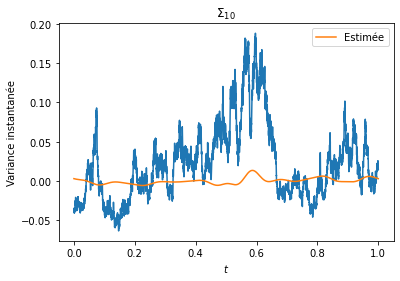

In [32]:
plt.plot(times, b10_exp)
plt.plot(vol_times_exp, sigma10_exp, label='Estimée')
plt.ylabel('Variance instantanée')
plt.xlabel('$t$')
plt.title('$\Sigma_{10}$')
plt.legend()

In [38]:
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.plot(times, b10_10)
plt.plot(vol_times_10, sigma10_10, label='Estimée')
plt.ylabel('Covariance instantanée', fontsize=15)
plt.xlabel('$t$', fontsize=15)
plt.title('$\Sigma_{10}$', fontsize=15)
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(times, b10_40)
plt.plot(vol_times_40, sigma10_40, label='Estimée')
plt.xlabel('$t$', fontsize=15)
plt.title('$\Sigma_{10}$', fontsize=15)
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(times, b10_exp)
plt.plot(vol_times_exp, sigma10_exp, label='Estimée')
plt.xlabel('$t$', fontsize=15)
plt.title('$\Sigma_{10}$', fontsize=15)
plt.legend()

In [37]:
%matplotlib qt